In [35]:
import os
import numpy as np
import pandas as pd

file_path = './test_results_r3.xlsx'

df_raw = pd.read_excel(file_path, engine='openpyxl')
df_raw = df_raw.loc[:, ~df_raw.columns.str.contains("Unnamed:")]

### ADC DAC split

In [17]:
df = df_raw.copy()

df = df[df['model']=='Resnet18']
df = df[df['read_noise_scale'] == 0]
df = df[df['drift_model'] == 'log_rev']
df = df[df['Gmin']=='default']
df = df[(df['inp_noise']==0.01)]
df = df[(df['GDC']=='on')]

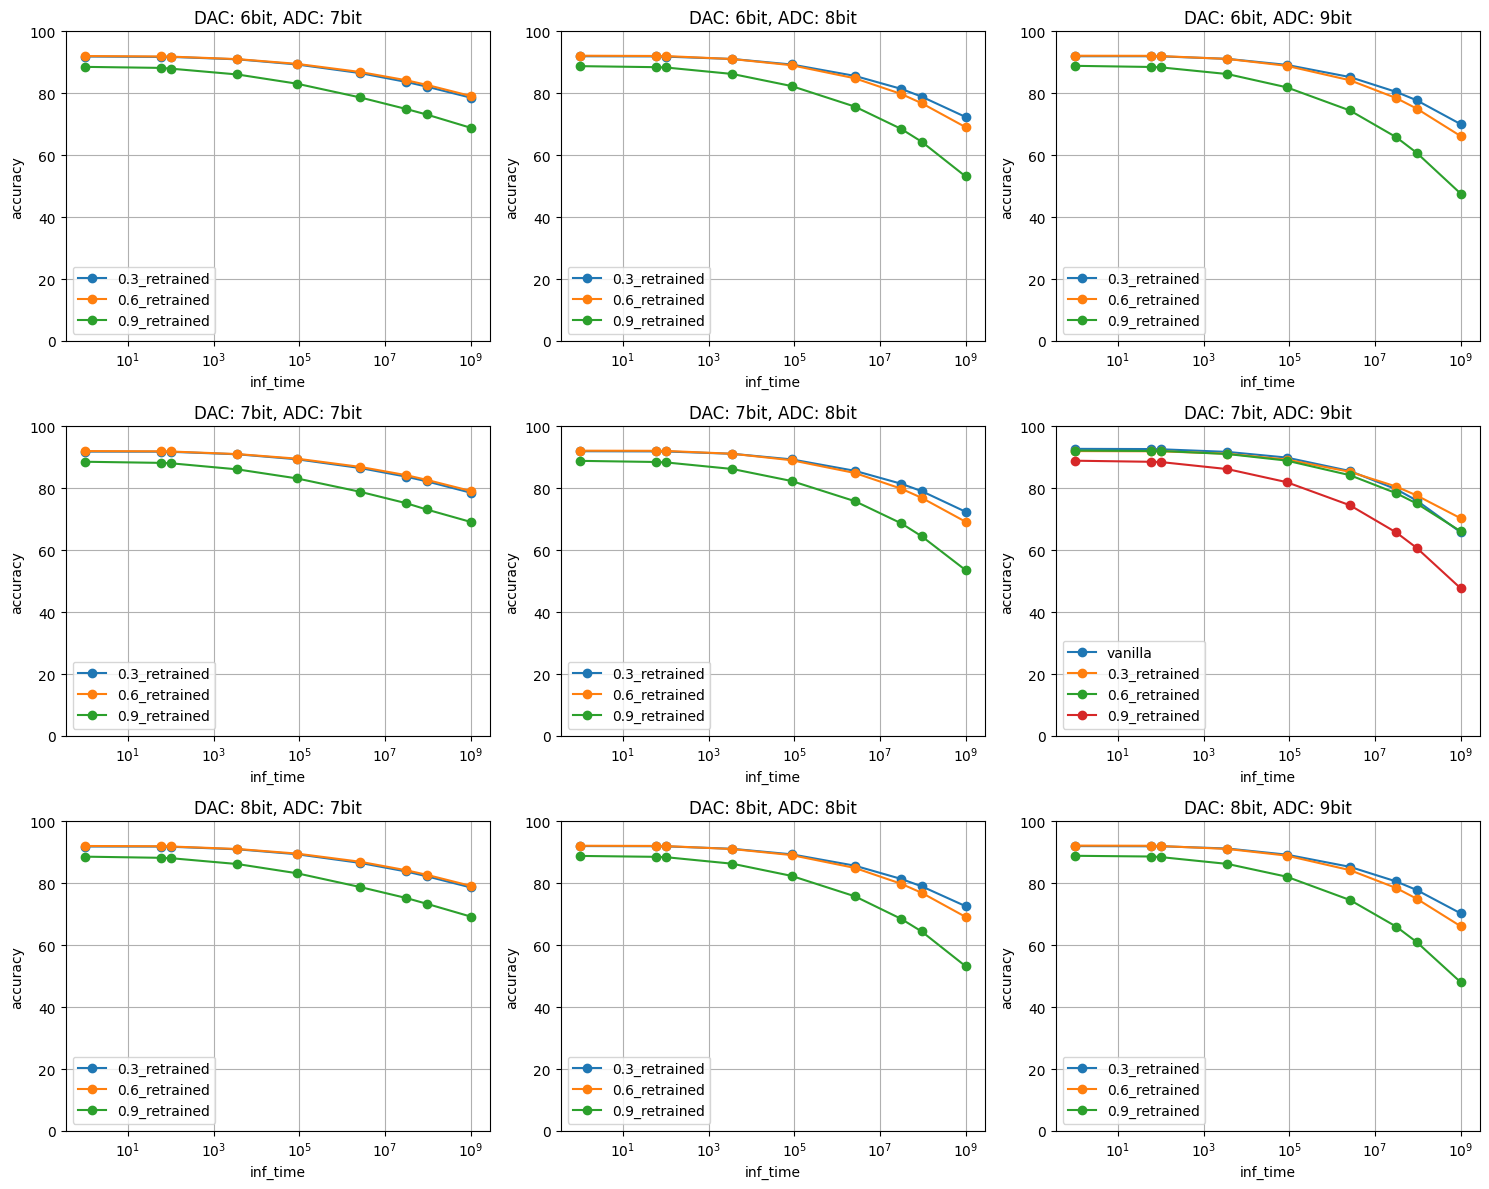

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# 예시용: rawdata = pd.read_csv("your_data.csv")

# 필요한 열이 존재하는지 확인

required_columns = {'inf_time', 'accuracy', 'model_type', 'dac_res', 'adc_res'}
assert required_columns.issubset(df.columns), "필수 column이 rawdata에 없습니다."

# 유일한 dac_res, adc_res 값 파악
dac_vals = sorted(df['dac_res'].unique())
adc_vals = sorted(df['adc_res'].unique())

# subplot 생성
fig, axes = plt.subplots(len(dac_vals), len(adc_vals), figsize=(5 * len(adc_vals), 4 * len(dac_vals)), squeeze=False)

# 각 subplot에 대해 plot
for i, dac in enumerate(dac_vals):
    for j, adc in enumerate(adc_vals):
        ax = axes[i][j]
        subset = df[(df['dac_res'] == dac) & (df['adc_res'] == adc)]
        for model in subset['model_type'].unique():
            model_data = subset[subset['model_type'] == model]
            ax.plot(model_data['inf_time'], model_data['accuracy'], label=model, marker='o')

        ax.set_title(f'DAC: {dac}, ADC: {adc}')
        ax.set_xlabel('inf_time')
        ax.set_ylabel('accuracy')
        ax.set_xscale('log')
        ax.set_ylim(0, 100)
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


## Mapping split

In [36]:
df = df_raw.copy()

df = df[df['model']=='Resnet18']
df = df[df['read_noise_scale'] == 0]
df = df[df['drift_model'] == 'log_rev']
df = df[df['Gmin']==0.1]
# df = df[(df['mapping_method']=='naive')]
df = df[df['Gmin']==0.1]
df = df[df['drift_noise_scale'] == 1]

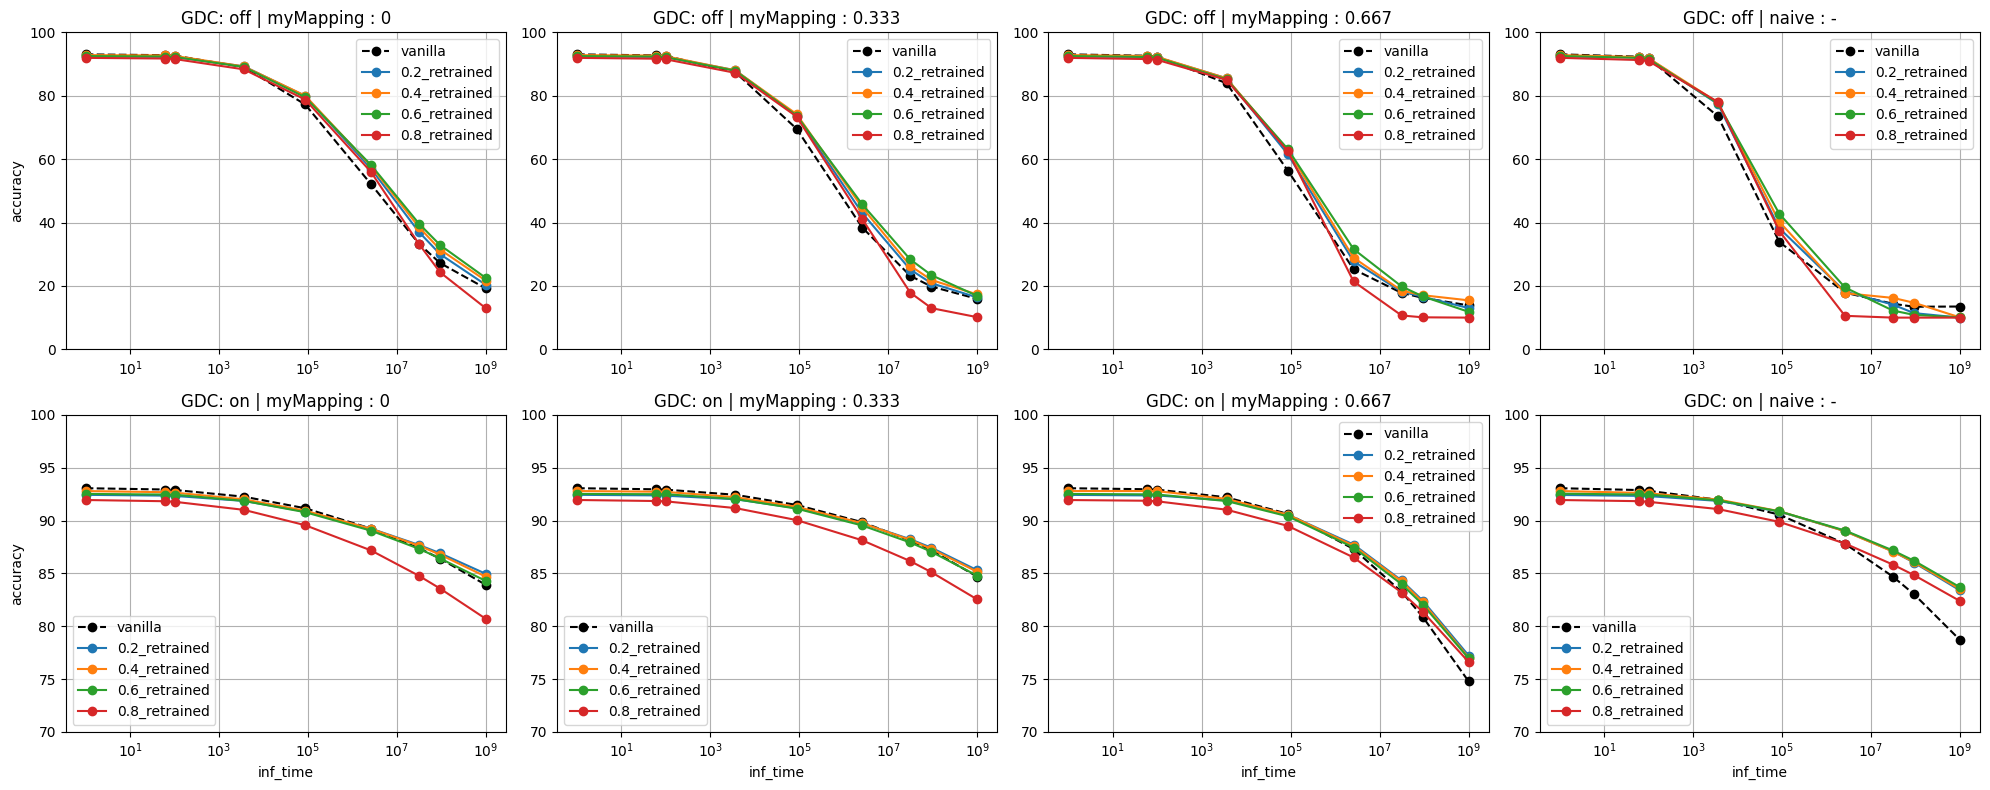

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# mapping_method 와 distortion_f 를 조합해서 새로운 column 생성
df['mapping_distortion'] = df['mapping_method'].astype(str) + ' : ' + df['distortion_f'].astype(str)

# 유일한 값 추출
gdc_vals = sorted(df['GDC'].unique())
mapping_distortion_vals = sorted(df['mapping_distortion'].unique())

# GDC (row), mapping_distortion (col)
fig, axes = plt.subplots(len(gdc_vals), len(mapping_distortion_vals),
                         figsize=(5 * len(mapping_distortion_vals), 4 * len(gdc_vals)),
                         squeeze=False)

# plot
for i, gdc in enumerate(gdc_vals):
    for j, mapping_distortion in enumerate(mapping_distortion_vals):
        ax = axes[i][j]
        subset = df[(df['GDC'] == gdc) & (df['mapping_distortion'] == mapping_distortion)]
        for model in subset['model_type'].unique():
            model_data = subset[subset['model_type'] == model].sort_values('inf_time')
            if model == 'vanilla':
                ax.plot(model_data['inf_time'], model_data['accuracy'],
                        label=model, color='black', linestyle='--', marker='o')
            else:
                ax.plot(model_data['inf_time'], model_data['accuracy'],
                        label=model, marker='o', linestyle='-')

        ax.set_title(f'GDC: {gdc} | {mapping_distortion}')
        if i == len(gdc_vals) - 1:
            ax.set_xlabel('inf_time')
        if j == 0:
            ax.set_ylabel('accuracy')

        if gdc == "on":
            ax.set_ylim(70, 100)
        else:
            ax.set_ylim(0, 100)

        ax.legend()
        ax.grid(True)
        ax.set_xscale('log')
        

plt.tight_layout()
plt.show()

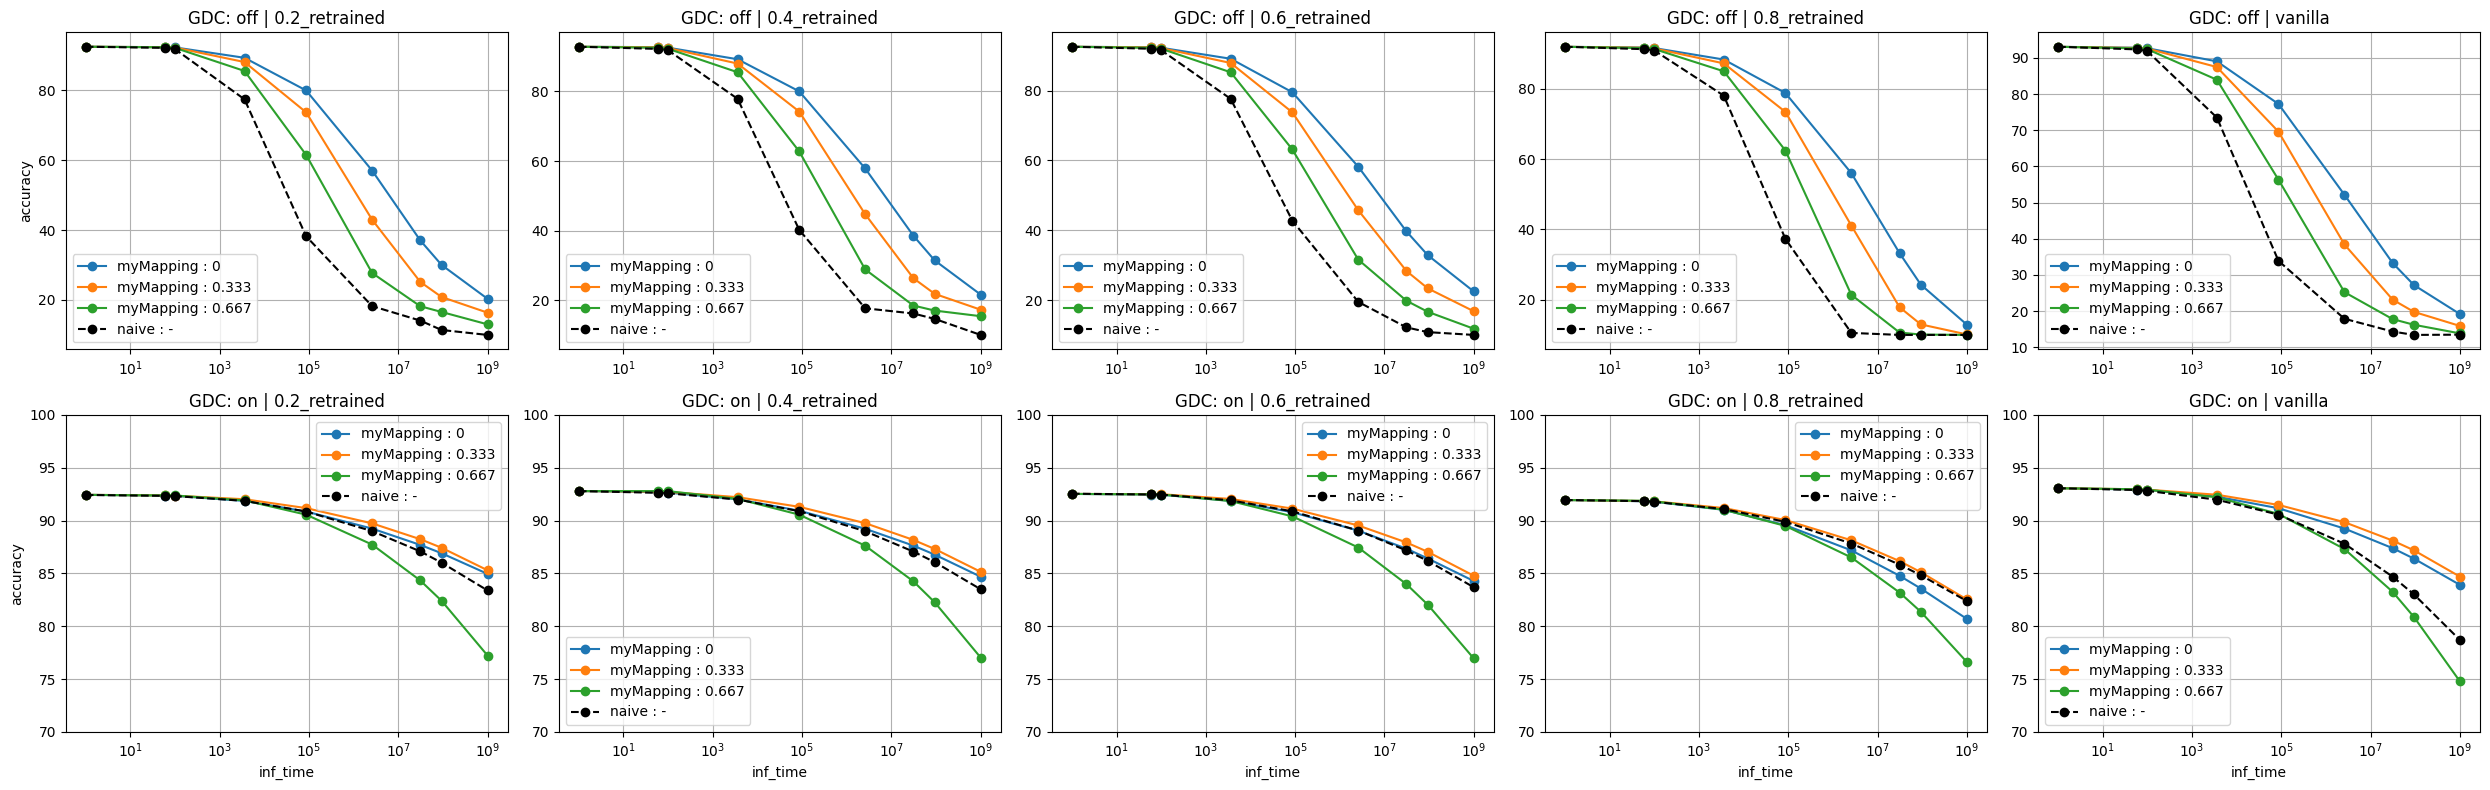

In [43]:
# 유일한 값 추출
gdc_vals = sorted(df['GDC'].unique())
model_vals = sorted(df['model_type'].unique())
mapping_distortion_vals = sorted(df['mapping_distortion'].unique())

# subplot 개수 정의 (row: GDC, col: model_type)
fig, axes = plt.subplots(len(gdc_vals), len(model_vals),
                         figsize=(5 * len(model_vals), 4 * len(gdc_vals)),
                         squeeze=False)

# plot
for i, gdc in enumerate(gdc_vals):
    for j, model in enumerate(model_vals):
        ax = axes[i][j]
        subset = df[(df['GDC'] == gdc) & (df['model_type'] == model)]

        for mapping_distortion in mapping_distortion_vals:
            md_data = subset[subset['mapping_distortion'] == mapping_distortion].sort_values('inf_time')

            if 'naive' in mapping_distortion:
                ax.plot(md_data['inf_time'], md_data['accuracy'],
                        label=mapping_distortion, color='black', linestyle='--', marker='o')
            else:
                ax.plot(md_data['inf_time'], md_data['accuracy'],
                        label=mapping_distortion, marker='o')

        ax.set_title(f'GDC: {gdc} | {model}')
        if i == len(gdc_vals) - 1:
            ax.set_xlabel('inf_time')
        if j == 0:
            ax.set_ylabel('accuracy')

        # GDC가 "on"일 때 ylim 설정
        if gdc == "on":
            ax.set_ylim(70, 100)


        ax.grid(True)
        ax.legend()
        ax.set_xscale('log')

plt.tight_layout()